Attempting to just catch the laminar flow without any cyinder interuption

In [1]:
from xpinn import XPINN
import jax.numpy as np
from utils import data_path

data_path = data_path / "NavierStokes"

n_interior = 400
n_boundary = 2100

file_train = data_path / "NoCylinder"/f"laminar_decomp_train_{n_interior}_{n_boundary}.json"
file_test = data_path / "test.json"

activation = np.tanh
xpinn = XPINN(file_train, activation)

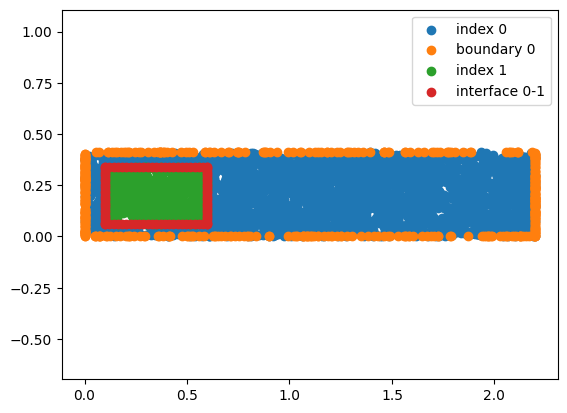

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.axis("equal"
)

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if i == 0:
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

In [3]:
from typing import Callable
from type_util import Params, Array
from base_network import neural_network
from jax import hessian, jit, vmap, grad, jacobian
import jax.numpy as np

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))

#### Advection term

In [4]:
psi = lambda params, xy: model(params, xy)[0]

hess_psi = hessian(psi, argnums=1)
d_psi_dxy = grad(psi, argnums=1)

def advection_term(params: Params, xy: Array) -> Array:
    hess = hess_psi(params, xy)
    processed_hess = np.array([[-hess[1, 1], hess[1, 0]], [hess[1, 0], -hess[0, 0]]])
    return processed_hess @ d_psi_dxy(params, xy)



#### Diffusion term

In [5]:
jacobi_hess_psi = jacobian(hess_psi, argnums=1)

def diffusion_term(params: Params, xy: Array):
    jachessi = jacobi_hess_psi(params, xy)
    u_diffusion = jachessi[0,1,0] + jachessi[1,1,1] #psi_yxx + psi_yyy
    v_diffusion = jachessi[1,0,1] + jachessi[0,0,0] #psi_xyy + psi_xxx
    return np.array([u_diffusion, -v_diffusion])

#### Pressure

In [6]:
p = lambda params, xy: model(params, xy)[1]

d_p = grad(p, argnums=1)

#### Navier stokes residual

In [7]:
def navier_stokes_residual_factory(index: int, nu:float, weight: int = 1) -> LFunc:

    def residual(params, xy):
        return np.sum(np.square(advection_term(params, xy) - nu* diffusion_term(params, xy) + d_p(params, xy)))

    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual
    
    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts)) * weight

    return interior_loss
    

#### Inflow

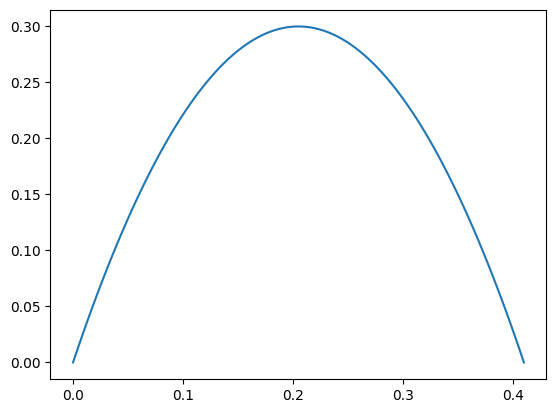

In [8]:
U = 0.3
inflow_func_1d = lambda x: 4*U*x*(0.41-x)/0.41**2
x = np.linspace(0, 0.41, 100)
plt.plot(x, inflow_func_1d(x))

In [9]:

inflow_func = lambda xy: np.array((4 * U * xy[1] * (0.41 - xy[1])/(0.41**2), 0.0))

In [10]:
def uv(params: Params, xy: Array) -> Array:
    d_psi = d_psi_dxy(params, xy)
    return np.array([d_psi[1], -d_psi[0]])

#### Boundary Losses
One of the PINNs has the cylinder and the other has the remainding boundaries. 
vmap throws an error if it gets a empty array, so we need two different
boundary losses 

In [11]:
def cylinder_boundary_loss_factory(weight: int = 1) -> LFunc:
    
    def wall_boundary_loss(params, xy):
        return np.sum(np.square(uv(params, xy))) #return u**2 + v**2
    
    v_wall_boundary_loss = vmap(wall_boundary_loss, (None, 0))
    
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:

        cylinder_pts = points['cylinder boundary']
        
        cylinder = v_wall_boundary_loss(params, cylinder_pts)
    
        return np.mean(cylinder)*weight
    
    return boundary_loss

In [16]:
from typing import Tuple

def boundary_loss_factory_no_cylinder(inflow_func: Callable[[Array], Array], nu:float, weights:Tuple[int, int, int]= (1,1,1) ) -> LFunc:
    
    def left_boundary_loss(params, xy):
        return np.sum(np.square(uv(params, xy) - inflow_func(xy))) #(u - inflow)**2 + v**2
        
    def right_boundary_loss(params, xy):
        return np.sum(np.square(nu*hess_psi(params, xy)[:,1] - np.array((p(params,xy), 0)))) # (nu*u_x-p)**2 + (nu*u_y)**2
        
    def wall_boundary_loss(params, xy):
        return np.sum(np.square(uv(params, xy))) #return u**2 + v**2
    
    v_wall_boundary_loss = vmap(wall_boundary_loss, (None, 0))
    v_left_boundary_loss = vmap(left_boundary_loss, (None, 0))
    v_right_boundary_loss = vmap(right_boundary_loss, (None, 0))
    
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:

        left_pts = points['left boundary']
        right_pts = points['right boundary']
        wall_pts = points['wall boundary']
    
        left = v_left_boundary_loss(params, left_pts)
        right = v_right_boundary_loss(params, right_pts)
        wall = v_wall_boundary_loss(params, wall_pts)
    
        
        all =  np.sum(np.array((np.mean(left)*weights[0], np.mean(wall)*weights[1], np.mean(right)*weights[2])))
        return all
    
    return boundary_loss

#### Interface loss

In [17]:
def interface_loss_factory(i: int, j: int) -> LFunc:
    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return 80 * (res_ij + avg_ij)

    return interface_loss

In [18]:
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory_no_cylinder(inflow_func, 0.001, (30,5,5))
p0.interior_loss = navier_stokes_residual_factory(0, 0.001, 20)


p1 = xpinn.PINNs[1]
p1.interior_loss = navier_stokes_residual_factory(1, 0.001, 30)

p0.interface_loss = interface_loss_factory(0, 1)
p1.interface_loss = interface_loss_factory(1, 0)

p0.create_loss()
p1.create_loss()

<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x00000171361080E0>>

In [19]:
import optax

shapes = [[2] + [20] * 8 + [1]] * 2

exponential_decay = optax.exponential_decay(
    init_value=0.001,
    transition_steps=10000,
    transition_begin=15000,
    decay_rate=0.1,
    end_value=0.0000001
)

optimizer = optax.adam(learning_rate=exponential_decay)

xpinn.initialize_params(shapes, optimizer)

C:\Users\dtsteene\OneDrive - Universitetet i Oslo\Documents\vår2024\FYS5429\FYS5429\Project1XPINNs\src\base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
C:\Users\dtsteene\OneDrive - Universitetet i Oslo\Documents\vår2024\FYS5429\FYS5429\Project1XPINNs\src\base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


In [20]:
n_iter = 20000
#losses = xpinn.run_iters(n_iter)

In [ ]:
from utils import model_path



no_cylinder_path = model_path / "NavierStokes"/ "Decomp"/ "laminar" / "NoCylinder"/f"ADAM_{n_iter}_iter_8layer"
#xpinn.save_model(no_cylinder_path)


Load and predict model

In [21]:
from utils import model_path

model_path = model_path / "NavierStokes" / "Decomp" / "laminar"

load_model_path = model_path / "NoCylinder" /f"ADAM_{n_iter}_iter_8layer"

xpinn.load_model(load_model_path)


In [22]:
uv = jit(vmap(uv, (None, 0)))
p = jit(vmap(p, (None, 0)))
j_model = jit(v_model)

In [29]:
def pinn_predict(params, args: dict[str, Array]):
    b = args["boundary"]
    i = args["interior"]
    if b.size == 0:
        points = i
    else:
        points = np.vstack([b, i])

    net_output = j_model(params, points)
    pressure = net_output[:, 1]
    pressure = p(params, points)
    streamfunction = net_output[:, 0]
    flow = uv(params, points)
    flow_magnitude = np.sqrt(np.sum(flow**2, axis=1))

    return points, flow, flow_magnitude, pressure, streamfunction

In [30]:
import json
from pathlib import Path

def predict(input_file: str | Path = None):
    if input_file:
        main_args = {}
        with open(input_file) as infile:
            data = json.load(infile)

        for i, item in enumerate(data["XPINNs"]):
            interior = np.asarray(item["Internal points"])
            boundary = np.asarray(item["Boundary points"])

            main_args[i] = {"boundary": boundary, "interior": interior}

    else:
        main_args = xpinn.main_args

    total_streamfunction = []
    total_points = []
    total_flow = []
    total_p = []
    total_flow_magnitude = []


    for i, pinn in enumerate(xpinn.PINNs):
        params = pinn.params
        points, flow, flow_magnitude, p, streamfunction = pinn_predict(params, main_args[i])
        
        total_flow_magnitude.append(flow_magnitude)
        total_streamfunction.append(streamfunction)
        total_points.append(points)
        total_flow.append(flow)
        total_p.append(p)

    return total_points, total_flow, total_flow_magnitude, total_p, total_streamfunction

In [31]:
points, flow, flow_magitude, pressure, streamfunction = predict(file_train)

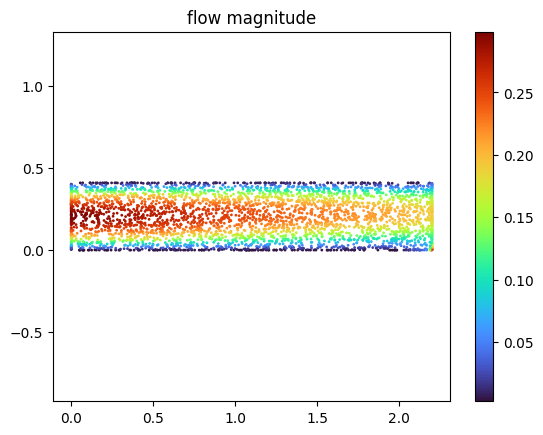

In [32]:
tot_flow_magnitude = np.concatenate(flow_magitude)
min_, max_ = tot_flow_magnitude.min(), tot_flow_magnitude.max()

for point, pred in zip(points, flow_magitude):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="Flow Magnitude", s=1)
plt.title("flow magnitude")
plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()

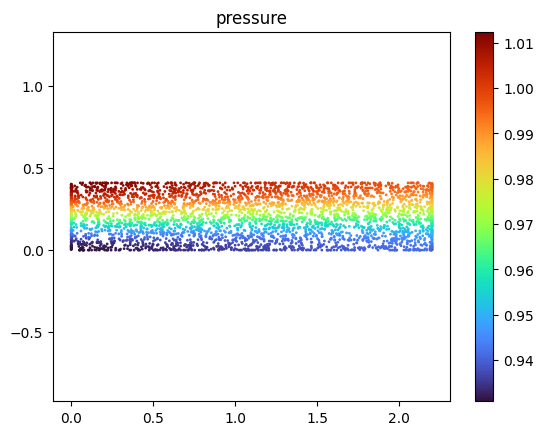

In [33]:
tot_pressure  =  np.concatenate(pressure)
min_, max_ = tot_pressure.min(), tot_pressure.max()

for point, pred in zip(points, pressure):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="pressure", s=1 )
plt.title("pressure")
plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()

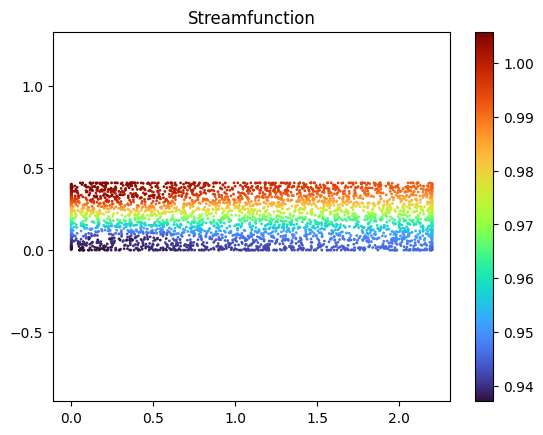

In [34]:
tot_streamfunction = np.concatenate(streamfunction)
in_, max_ = tot_streamfunction.min(), tot_streamfunction.max()


for point, pred in zip(points, streamfunction):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="streamfunction", s=1)
plt.title("Streamfunction")
#plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()
